# Generate auto- or cross-correlation function between 2 given catalogs

In [1]:
import os
import tempfile
import time
import copy

import numpy as np
import scipy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 12})

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, BoxSubsampler, project_to_wp, utils, setup_logging
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *

import catalog_data
import density_split

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = density_split.DensitySplit.load(output_dir+catalog.name+'_density_split.npy')
catalog.shift_boxcenter(-catalog.offset)

## Generate random catalogs

In [4]:
# Generate random catalogs to compare catalog with when computing correlation function
def generate_catalogs(size, boxsize, offset, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    return positions
    
catalog_randoms_positions = generate_catalogs(size=6*catalog.size, boxsize=(catalog.boxsize,)*3, offset=(catalog.offset,)*3)
split_samples = catalog.sample_splits(size=6*catalog.size, seed=42, update=True)

## Correlation function of each density split

In [5]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

results = list()

for i in range(catalog.nsplits):
    result = TwoPointCorrelationFunction('smu', edges,
                                         data_positions1=catalog.split_positions[i],
                                         boxsize=catalog.boxsize,
                                         engine='corrfunc', nthreads=128,
                                         los = 'x')

    result_wRandoms = TwoPointCorrelationFunction('smu', edges,
                                                  data_positions1=catalog.split_positions[i],
                                                  randoms_positions1=catalog_randoms_positions,
                                                  engine='corrfunc', nthreads=128,
                                                  los = 'x')
    
    result_wSplitRandoms = TwoPointCorrelationFunction('smu', edges,
                                                  data_positions1=catalog.split_positions[i],
                                                  randoms_positions1=catalog.split_samples[i],
                                                  engine='corrfunc', nthreads=128,
                                                  los = 'x')
    
    split_dict = {'gg': result, 
                  'gg_wRandoms': result_wRandoms, 
                  'gg_wSplitRandoms': result_wSplitRandoms} 

    results.append(split_dict)

In [11]:
np.save(output_dir+catalog_name+'_2PCF_randoms_tests', results)

In [6]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
nells = len(ells)

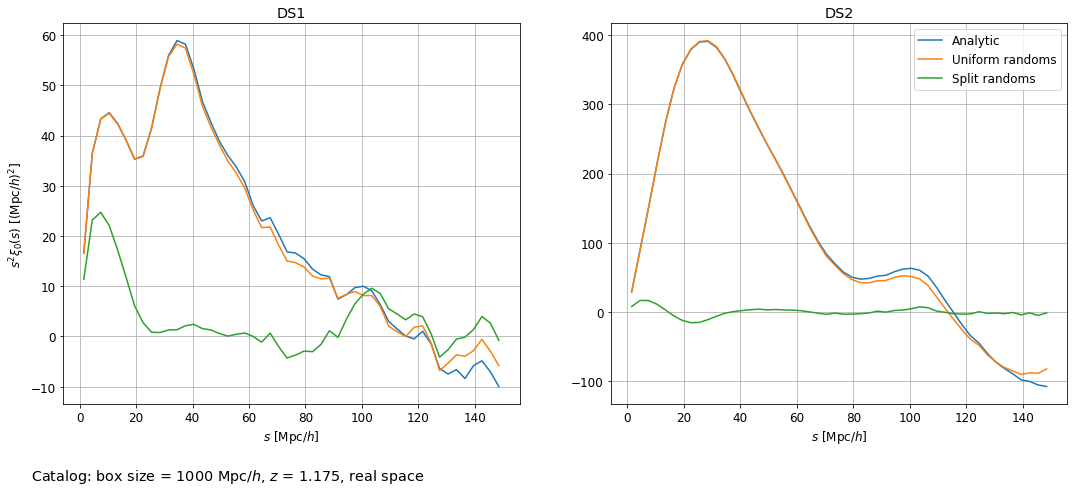

In [10]:
plt.rcParams["figure.figsize"] = (18, 7)
fig, axes = plt.subplots(1, 2, sharey=False)

for i in range(catalog.nsplits):
    results_dict = results[i]
    
    s, xiell_gg = results_dict['gg'].get_corr(ells=ells, return_sep=True)
    xiell_gg_wRandoms = results_dict['gg_wRandoms'].get_corr(ells=ells, return_sep=False)
    xiell_gg_wSplitRandoms = results_dict['gg_wSplitRandoms'].get_corr(ells=ells, return_sep=False)

    axes[i].plot(s, s**2 * xiell_gg[0], label='Analytic')
    axes[i].plot(s, s**2 * xiell_gg_wRandoms[0], label='Uniform randoms')
    axes[i].plot(s, s**2 * xiell_gg_wSplitRandoms[0], label='Split randoms')
    
    axes[i].grid(True)
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    axes[i].set_title('DS{}'.format(i+1))
    
axes[0].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.redshift),
             ha='left', x=0.1, y=0)

plt.legend()
plt.show()